In [13]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID" 
os.environ["CUDA_VISIBLE_DEVICES"]="0"

import json
import pickle as pkl

import numpy as np
import torch
# from persite_painn.nn.models import Painn

from torch.utils.data import DataLoader
from persite_painn.data import collate_dicts
from persite_painn.nn.builder import get_model_list
from persite_painn.utils import ensemble_inference
from persite_painn.data.preprocess import convert_site_prop
# from persite_painn.train import Normalizer, load_model"
from persite_painn.utils import plot_hexbin, inference, Normalizer, get_metal_idx, get_metal_idx_batch, ensemble_inference, plot_violin, get_metal_specie, get_metal_filter, plot_scatter, set_size
from persite_painn.data import Dataset, split_train_test, build_dataset
from persite_painn.utils.cuda import batch_to
import matplotlib.pyplot as plt
# from nff.data import Dataset
from typing import Dict
from tqdm import tqdm
from sklearn.cluster import KMeans, DBSCAN
from scipy.stats import norm
from sklearn.decomposition import PCA
from persite_painn.utils.postprocess import getdGs_tensor, getOverpotential_tensor
import seaborn as sns

from scipy import stats
import pandas as pd
from sklearn.manifold import TSNE

Download torch dataset `search_space_2_components` from our zenodo dataset [here](https://zenodo.org/records/10119944) to the `data_cache` folder.


In [2]:
unlabelled_dataset = torch.load("../data_cache/search_space_2_components")
total_data_loader = DataLoader(
    unlabelled_dataset,
    batch_size=64,
    num_workers=0,
    collate_fn=collate_dicts,
)

In [3]:
model_path = "models/m_painn/2_components/"
model_list = get_model_list(model_path=model_path, model_type="PainnMultifidelity")

In [4]:
def get_ensemble_hook(model_list):
    features = {}
    def get_atom_features(name):
        def hook(model, input, output):
            features[name] = output.detach()
        return hook
    hook_list = []
    for i, model in enumerate(model_list):
        hook=model.readout_block.readoutdict['atom_emb'][-1].register_forward_hook(get_atom_features(f"atom_emb"+str(i)))
        hook_list.append(hook)
    return features, hook_list

def remove_ensemble_hook(hook_list):
    for hook in hook_list:
        hook.remove()

In [5]:
features, hook_list = get_ensemble_hook(model_list)

In [6]:
embedding_bin= []
oer_bin = []
orr_bin = []
ads_bin = []
device = "cuda"
for batch in tqdm(total_data_loader):
    batch = batch_to(batch, device)
    metal_filter = get_metal_filter(batch)
    embedding_tmp = []
    oer_tmp = []
    orr_tmp = []
    ads_tmp = []
    batch_atom_len = batch["nxyz"].shape[0]
    for i, model in enumerate(model_list):
        model.eval()
        model.device = device
        model.to(device)
        out = model(batch, inference=True)["target"]
        embedding = features[f"atom_emb{i}"]
        new_embedding = embedding[metal_filter].unsqueeze(-1)
        dGs_tensor = getdGs_tensor(out)[metal_filter]
        GOads = dGs_tensor[:,0]
        GOHads = dGs_tensor[:,1]
        ads = GOads-GOHads
        oer_output, orr_output,_, _ = getOverpotential_tensor(dGs_tensor)
        # print(oer_output.shape)
        # print(new_embedding.shape, oer_output.unsqueeze(-1).shape, orr_output.unsqueeze(-1).shape)
        embedding_tmp.append(new_embedding)
        oer_tmp.append(oer_output.unsqueeze(-1))
        orr_tmp.append(orr_output.unsqueeze(-1))
        ads_tmp.append(ads.unsqueeze(-1))

    val = torch.mean(torch.cat(embedding_tmp, dim=2), dim=2).squeeze(-1)
    val_oer = torch.mean(torch.cat(oer_tmp, dim=1), dim=1).squeeze(-1)
    val_orr = torch.mean(torch.cat(orr_tmp, dim=1), dim=1).squeeze(-1)
    val_ads = torch.mean(torch.cat(ads_tmp, dim=1), dim=1).squeeze(-1)
    for embedding in val:
        embedding_bin.append(embedding.cpu().numpy())
    for oer in val_oer:
        oer_bin.append(oer.cpu().numpy() * -1)
    for orr in val_orr:
        orr_bin.append(orr.cpu().numpy()* -1)
    for a in val_ads:
        ads_bin.append(float(a.cpu().numpy()))
remove_ensemble_hook(hook_list=hook_list)

100%|██████████| 238/238 [00:55<00:00,  4.28it/s]


In [12]:
X_multifidelity = np.array(embedding_bin)

# pca = PCA(n_components=8).fit(X_multifidelity)
tsne = TSNE(n_components=2, perplexity=150, random_state=123)
# df_pca = pca.transform(X_multifidelity)
df_tsne = tsne.fit_transform(X_multifidelity)

/home2/hojechun/.conda/envs/SingleAtom/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:795: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home2/hojechun/.conda/envs/SingleAtom/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


/tmp/ipykernel_2268802/4137349281.py:13: UserWarning: Use the colorbar set_ticks() method instead.
  cbar.ax.set_yticks([-4,-3,-2,-1])


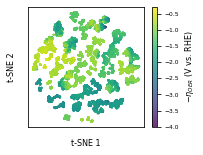

In [10]:
# color_dict = {22: "#d53e4f", 23: "#f46d43", 24: "#fdae61", 25: "#fee08b", 26: "#8073ac", 27: "#abd9e9", 28: "#abdda4", 29: "#66c2a5", 30: "#3288bd"}

with plt.style.context("seaborn-bright"):

    fig = plt.figure(figsize=(2.6, 2.20084768))

    cm = plt.cm.get_cmap("viridis")
    ax = fig.add_subplot()
    im = ax.scatter(df_tsne[:,0], df_tsne[:,1], s=2, alpha=0.8, c = oer_bin, cmap=cm)
    im.set_clim(-4,-.3)
    cbar = fig.colorbar(im, ax=ax, pad=0.05)
    cbar.set_label(label="$-\eta_{OER}$ (V vs. RHE)", size=8)
    cbar.ax.set_yticks([-4,-3,-2,-1])
    cbar.ax.tick_params(labelsize=6)
    ax.set_yticklabels("")
    ax.set_xticklabels("")
    ax.set_xlabel("t-SNE 1", fontsize=8, labelpad=5)
    ax.set_ylabel("t-SNE 2", fontsize=8, labelpad=5)
    ax.tick_params(left=False, bottom=False)


# fig.savefig("oer_activity_0712.png", dpi=500, transparent=True,bbox_inches='tight')

/tmp/ipykernel_2268802/1381589787.py:9: UserWarning: Use the colorbar set_ticks() method instead.
  cbar.ax.set_yticks([-4,-3,-2,-1])


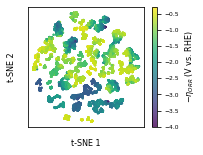

In [11]:

with plt.style.context("seaborn-bright"):
    fig = plt.figure(figsize=(2.6, 2.20084768))
    cm = plt.cm.get_cmap("viridis")
    ax = fig.add_subplot()
    im = ax.scatter(df_tsne[:,0], df_tsne[:,1], s=2, alpha=0.8, c = orr_bin, cmap=cm)
    im.set_clim(-4,-.3)
    cbar = fig.colorbar(im, ax=ax, pad=0.05)
    cbar.set_label(label="$-\eta_{ORR}$ (V vs. RHE)", size=8)
    cbar.ax.set_yticks([-4,-3,-2,-1])
    cbar.ax.tick_params(labelsize=6)
    ax.set_xlabel("Principal component 1")
    ax.set_ylabel("Principal component 2")
    ax.set_yticklabels("")
    ax.set_xticklabels("")
    ax.set_xlabel("t-SNE 1", fontsize=8, labelpad=5)
    ax.set_ylabel("t-SNE 2", fontsize=8, labelpad=5)
    ax.tick_params(left=False, bottom=False)


# fig.savefig("orr_activity_0712.png", dpi=500, transparent=True,bbox_inches='tight')